In [1]:
# libraries used
import boto3
#import diff_classifier.aws as aws
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#from diff_classifier.features import calculate_features
from os import listdir, getcwd, chdir
from os.path import isfile, join
import os
#import diff_predictor
#from diff_predictor import spatial
from matplotlib import colors as plt_colors

import altair as alt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn import preprocessing

import xgboost as xgb


import shap

In [2]:
workbookDir = getcwd()
print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /mnt/batch/tasks/shared/LS_root/mounts/clusters/nancelabgpu/code/Users/nlsschim
Using current directory for loading data: /mnt/batch/tasks/shared/LS_root/mounts/clusters/nancelabgpu/code/Users


In [4]:
dataset_path = workbookDir + '/nlsschim/0.8s_deff2_features_ecm/'
#msd_path = workbookDir + '/nlsschim/raw_data_pnn/'
filelist = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f)) and 'feat' in f]
#msd_filelist = [f for f in listdir(msd_path) if isfile(join(msd_path, f)) and 'msd' in f]
#print(len(msd_filelist))
print(len(filelist))

180


In [8]:
# output_path = workbookDir + '/Users/nlsschim/features_ecm/'
# feat_filelist = [f for f in listdir(output_path) if isfile(join(output_path, f)) and 'features' in f]
# len(feat_filelist)

In [9]:
# remaining_msd = msd_filelist[58:]
# remaining_msd

In [10]:
# msd_df = pd.read_csv(msd_path + str(msd_filelist[0]))
# msd_df.head()

In [11]:
# for file in remaining_msd:
#     msd_df = pd.read_csv(msd_path+str(file))
#     print('starting: ' + file)
#     fea_df = calculate_features(msd_df, mean_values=True)
#     path = workbookDir
#     fname = 'features' + file[3:]
#     full_str = path + '/nlsschim/features_ecm/' + fname
#     fea_df.to_csv(full_str)
#     print(full_str)
#     print('')

In [5]:
fstats_tot = None
video_num = 0
for filename in filelist:
#     try:
        fstats = pd.read_csv(dataset_path + filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
        print('{} size: {}'.format(filename, fstats.shape))
        #if 'HYase' in filename:
            #fstats['Treatment'] = pd.Series(fstats.shape[0]*['HYase'], index=fstats.index)
        if 'ChABC' in filename:
            fstats['Treatment'] = pd.Series(fstats.shape[0]*['ChABC'], index=fstats.index)
        elif 'NT' in filename:
            fstats['Treatment'] = pd.Series(fstats.shape[0]*['NT'], index=fstats.index)
        else:
            print('Error, no target')
        fstats['Video Number'] = pd.Series(fstats.shape[0]*[video_num], index=fstats.index)
        if fstats_tot is None:
            fstats_tot = fstats
        else:
            fstats_tot = fstats_tot.append(fstats, ignore_index=True)
        video_num += 1

features_ChABC_brain_1_slice_1_vid_1.csv size: (502, 67)
features_ChABC_brain_1_slice_1_vid_2.csv size: (1734, 67)
features_ChABC_brain_1_slice_1_vid_3.csv size: (593, 67)
features_ChABC_brain_1_slice_1_vid_4.csv size: (258, 67)
features_ChABC_brain_1_slice_1_vid_5.csv size: (888, 67)
features_ChABC_brain_1_slice_2_vid_1.csv size: (1350, 67)
features_ChABC_brain_1_slice_2_vid_2.csv size: (690, 67)
features_ChABC_brain_1_slice_2_vid_3.csv size: (1257, 67)
features_ChABC_brain_1_slice_2_vid_4.csv size: (1070, 67)
features_ChABC_brain_1_slice_2_vid_5.csv size: (1097, 67)
features_ChABC_brain_1_slice_3_vid_1.csv size: (1141, 67)
features_ChABC_brain_1_slice_3_vid_2.csv size: (1307, 67)
features_ChABC_brain_1_slice_3_vid_3.csv size: (650, 67)
features_ChABC_brain_1_slice_3_vid_4.csv size: (1594, 67)
features_ChABC_brain_1_slice_3_vid_5.csv size: (1212, 67)
features_ChABC_brain_2_slice_1_vid_1.csv size: (1133, 67)
features_ChABC_brain_2_slice_1_vid_2.csv size: (2291, 67)
features_ChABC_brain

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features_HYase_brain_1_slice_1_vid_2.csv size: (1264, 67)
Error, no target
features_HYase_brain_1_slice_1_vid_3.csv size: (978, 67)
Error, no target
features_HYase_brain_1_slice_1_vid_4.csv size: (984, 67)
Error, no target
features_HYase_brain_1_slice_1_vid_5.csv size: (1439, 67)
Error, no target
features_HYase_brain_1_slice_2_vid_1.csv size: (1233, 67)
Error, no target
features_HYase_brain_1_slice_2_vid_2.csv size: (1906, 67)
Error, no target
features_HYase_brain_1_slice_2_vid_3.csv size: (2156, 67)
Error, no target
features_HYase_brain_1_slice_2_vid_4.csv size: (2428, 67)
Error, no target
features_HYase_brain_1_slice_2_vid_5.csv size: (1733, 67)
Error, no target
features_HYase_brain_1_slice_3_vid_1.csv size: (1565, 67)
Error, no target
features_HYase_brain_1_slice_3_vid_2.csv size: (1673, 67)
Error, no target
features_HYase_brain_1_slice_3_vid_3.csv size: (1538, 67)
Error, no target
features_HYase_brain_1_slice_3_vid_4.csv size: (653, 67)
Error, no target
features_HYase_brain_1_slice

In [6]:
fstats_tot

,AR,D_fit,Deff1,Deff2,MSD_ratio,Mean AR,Mean D_fit,Mean Deff1,Mean Deff2,Mean MSD_ratio,...,asymmetry2,asymmetry3,boundedness,efficiency,elongation,fractal_dim,frames,kurtosis,straightness,trappedness
0,1.580388,13.058749,11.974061,4.810263,0.076122,1.776560,24.568146,10.442310,4.451292,0.094254,...,0.541468,0.045251,0.055654,0.523548,0.367244,1.748594,35.0,2.551438,0.148739,-0.210243
1,2.116028,6.079955,NaN,NaN,-0.021291,3.084343,14.646033,14.047563,NaN,-0.044283,...,0.220988,0.227570,0.124585,0.573525,0.527416,1.851357,10.0,2.095601,0.300926,-0.189470
2,4.052659,23.212111,14.047563,NaN,-0.067275,3.084343,14.646033,14.047563,NaN,-0.044283,...,0.061313,0.496155,0.083099,1.224575,0.753248,1.319474,11.0,1.744405,0.386387,-0.201929
3,1.159049,82.989569,12.349498,2.362716,0.234767,1.565429,65.159873,19.066433,8.930125,0.315902,...,0.669754,0.019753,0.078294,0.205681,0.137224,1.799729,31.0,1.882246,0.096621,-0.203381
4,1.324925,8.442376,17.735803,15.497534,0.099991,1.565429,65.159873,19.066433,8.930125,0.315902,...,0.372241,0.110529,0.058218,0.430494,0.245240,1.729468,30.0,3.135845,0.153695,-0.209464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215888,1.703328,1.878042,4.658467,NaN,-0.082840,3.490935,5.341056,2.401253,1.193504,1.117825,...,0.364298,0.114914,0.104360,0.995023,0.412914,1.550060,11.0,2.161579,0.376036,-0.195528
215889,2.174046,30.508017,5.517628,NaN,0.358095,2.905565,18.635410,5.000972,4.267298,0.278980,...,0.114323,0.379597,0.144299,0.253036,0.540028,2.062300,22.0,2.022545,0.139355,-0.183595
215890,1.474390,0.143032,2.081575,1.376188,0.018438,2.414496,3.189233,1.825089,1.774337,0.641572,...,0.294501,0.160768,0.057245,0.890234,0.321754,1.722714,40.0,1.501659,0.200744,-0.209760
215891,3.421029,1.753419,5.199663,NaN,-0.138510,3.490935,5.341056,2.401253,1.193504,1.117825,...,0.064709,0.487493,0.070868,4.836462,0.707690,1.143037,11.0,1.756550,0.730551,-0.205627


In [13]:
fstats_tot.shape

(215893, 69)

In [15]:
fstats_tot[columns].isnull().sum()/len(fstats_tot)


alpha                0.002033
D_fit                0.002033
kurtosis             0.000009
asymmetry1           0.000009
asymmetry2           0.000009
asymmetry3           0.000009
AR                   0.000009
elongation           0.000009
boundedness          0.000009
fractal_dim          0.000009
trappedness          0.000009
efficiency           0.000009
straightness         0.000009
MSD_ratio            0.000009
frames               0.000000
Deff1                0.146716
Deff2                0.660383
Mean alpha           0.000079
Mean D_fit           0.000079
Mean kurtosis        0.000051
Mean asymmetry1      0.000051
Mean asymmetry2      0.000051
Mean asymmetry3      0.000051
Mean AR              0.000051
Mean elongation      0.000051
Mean boundedness     0.000051
Mean fractal_dim     0.000051
Mean trappedness     0.000051
Mean efficiency      0.000051
Mean straightness    0.000051
Mean MSD_ratio       0.000051
Mean Deff1           0.006753
Mean Deff2           0.113714
X         

In [7]:
# The column Deff2 currently has a super high number (~97%) of null values, so might be worth not including
# As such, it is commented out below
columns = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
    'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    'Mean alpha',
    'Mean D_fit',
    'Mean kurtosis',
    'Mean asymmetry1',
    'Mean asymmetry2',
    'Mean asymmetry3',
    'Mean AR',
    'Mean elongation',
    'Mean boundedness',
    'Mean fractal_dim',
    'Mean trappedness',
    'Mean efficiency',
    'Mean straightness',
    'Mean MSD_ratio',
    'Mean Deff1',
    'Mean Deff2',
    'X',
    'Y',
    'Treatment'
]

target = 'Treatment'

ecm = fstats_tot[columns]#.drop(['Deff2', 'Mean Deff2', 'Std Deff2'], axis=1) # Removing since 97% is null
#ecm['Treatment'] = fstats_tot['Treatment'].values
ecm = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)] # removes rows with nan or inf points


In [8]:
ecm.shape

(48404, 36)

In [9]:
# Make sure classes are balanced. 
# I'm debating if this is needed since the classes are pretty balanced already

def balance_data(df, target, **kwargs):
    if 'random_state' not in kwargs:
        random_state = 1
    else:
        random_state = kwargs['random_state']
    df_target = []
    bal_df = []
    for name in df[target].unique():
        df_target.append((name, df[df[target] == name]))
    print(f"Ratio before data balance ({':'.join([str(i[0]) for i in df_target])}) = {':'.join([str(len(i[1])) for i in df_target])}")
    for i in range(len(df_target)):
        ratio = min([len(i[1]) for i in df_target])/len(df_target[i][1])
        bal_df.append(df_target[i][1].sample(frac=ratio, random_state=random_state))
    print(f"Ratio after balance ({':'.join([str(i[0]) for i in df_target])}) = {':'.join([str(len(i)) for i in bal_df])}")
    return pd.concat(bal_df)
bal_ecm = balance_data(ecm, target, random_state=1)

Ratio before data balance (ChABC:NT) = 21715:26689
Ratio after balance (ChABC:NT) = 21715:21715


In [17]:
bal_ecm.isna().sum() #binx currently gives 8 nan values, preventing binning

alpha                0
D_fit                0
kurtosis             0
asymmetry1           0
asymmetry2           0
asymmetry3           0
AR                   0
elongation           0
boundedness          0
fractal_dim          0
trappedness          0
efficiency           0
straightness         0
MSD_ratio            0
frames               0
Deff1                0
Deff2                0
Mean alpha           0
Mean D_fit           0
Mean kurtosis        0
Mean asymmetry1      0
Mean asymmetry2      0
Mean asymmetry3      0
Mean AR              0
Mean elongation      0
Mean boundedness     0
Mean fractal_dim     0
Mean trappedness     0
Mean efficiency      0
Mean straightness    0
Mean MSD_ratio       0
Mean Deff1           0
Mean Deff2           0
X                    0
Y                    0
Treatment            0
dtype: int64

In [10]:
resolution = 128
assert not 2048%resolution and resolution >= 128, "resolution needs to be a factor of 2048 and > 128"
bins = list(range(0, 2048+1, resolution))
bin_labels = [int(i/resolution) for i in bins][:-1]
bal_ecm['binx'] = pd.cut(bal_ecm['X'], bins, labels=bin_labels, include_lowest=True)
bal_ecm.loc[bal_ecm['X'] < 0] = 0 # Set any X coordinates that are less than 0 to zero
bal_ecm['biny'] = pd.cut(bal_ecm.Y, bins, labels=bin_labels, include_lowest=True)
bal_ecm['bins'] = (len(bins)-1)*bal_ecm['binx'].astype(np.int32) + bal_ecm['biny'].astype(np.int32)
bal_ecm = bal_ecm[np.isfinite(bal_ecm['bins'])]
bal_ecm['bins'] = bal_ecm['bins'].astype(int)

In [11]:
bal_ecm.shape

(43430, 39)

In [12]:
label_df = bal_ecm['Treatment']
features_df = bal_ecm.drop(['Treatment', 'X', 'Y', 'binx', 'biny', 'bins'], axis=1)

# ss = StandardScaler()
# #scaled_features_df = ss.fit_transform(features_df)
# scaled_df = pd.DataFrame(ss.fit_transform(features_df.values), columns=features_df.columns)
# scaled_df['Treatment'] = label_df.values
# scaled_df

In [13]:
features = features_df.columns

In [14]:
bal_ecm.tail()

,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,fractal_dim,...,Mean straightness,Mean MSD_ratio,Mean Deff1,Mean Deff2,X,Y,Treatment,binx,biny,bins
172484,0.811948,17.607719,2.450348,0.997635,0.024330,0.604448,5.483697,0.817641,0.018715,1.398680,...,0.221187,0.374400,6.331606,5.260367,1696.699620,1915.083522,NT,13,14,222
149507,0.302202,23.093704,2.345038,0.675035,0.312942,0.147247,2.334452,0.571634,0.051023,2.045873,...,0.176262,0.496134,7.124501,4.793507,2038.532349,1405.767328,NT,15,10,250
177057,2.078559,0.651242,2.412153,0.871880,0.185101,0.269724,1.932619,0.482567,0.023685,1.539599,...,0.313631,0.925479,9.655354,9.175913,465.818370,227.485520,NT,3,1,49
157543,1.073337,9.955746,3.193648,0.971746,0.084646,0.440211,3.476600,0.712363,0.039494,1.538608,...,0.194242,0.009928,14.675919,11.675002,871.404923,1957.773943,NT,6,15,111
185843,2.038974,0.304343,3.028155,0.757300,0.263415,0.186271,1.046185,0.044146,0.051393,1.779825,...,0.185461,1.210588,4.791183,2.861600,1158.376342,590.272824,NT,9,4,148


In [15]:
# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


In [16]:
#Check lengths of datasets:
def get_lengths(df, X_train, X_test, X_val=None):
    print(f'Tot before split: {len(df)}')
    print(f'Training: {len(X_train)} ({len(X_train)/len(bal_ecm):.3f}%)')
    print(f'Testing: {len(X_test)} ({len(X_test)/len(bal_ecm):.3f}%)')
    try:
        print(f'Evaluation: {len(X_val)} ({len(X_val)/len(bal_ecm):.3f}%)')
    except:
        pass
get_lengths(bal_ecm, X_train, X_test, X_val)

Tot before split: 43430
Training: 21701 (0.500%)
Testing: 10865 (0.250%)
Evaluation: 10864 (0.250%)


In [17]:
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 2,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
         # GPU integration will cut time in ~half:
         'gpu_id' : 0,
         'tree_method': 'gpu_hist',
         'predictor': 'gpu_predictor'
         }

best_boost_rounds = 477

In [18]:
model = xgb.XGBClassifier()

In [19]:
def train(param, dtrain, dtest, dval=None, evals=[(dtrain, 'train')], num_round=40):
    if dval is not None and (dval, 'eval') not in evals:
        evals += [(dval, 'eval')]
    model = xgb.train(param, dtrain, num_round, evals, )
    true_label = dtest.get_label()
    ypred = model.predict(dtest)
    preds = [np.where(x == np.max(x))[0][0] for x in ypred]
    acc = metrics.accuracy_score(true_label, preds)
    print("Accuracy:",acc)
    return model, acc, true_label, preds
#booster, acc, true_label, preds = train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=best_boost_rounds)

In [20]:
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException

def cv(params, X_train, y_train, features=None, num_boost_round=20, nfold=3, stratified=False, folds=None,
       metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None,
       fpreproc=None, as_pandas=True, verbose_eval=100, show_stdv=True,
       seed=0, callbacks=None, shuffle=True):
    # pylint: disable = invalid-name
    """Cross-validation with given parameters.

    Parameters
    ----------
    params : dict
        Booster params.
    dtrain : DMatrix
        Data to be trained.
    num_boost_round : int
        Number of boosting iterations.
    nfold : int
        Number of folds in CV.
    stratified : bool
        Perform stratified sampling.
    folds : a KFold or StratifiedKFold instance or list of fold indices
        Sklearn KFolds or StratifiedKFolds object.
        Alternatively may explicitly pass sample indices for each fold.
        For ``n`` folds, **folds** should be a length ``n`` list of tuples.
        Each tuple is ``(in,out)`` where ``in`` is a list of indices to be used
        as the training samples for the ``n`` th fold and ``out`` is a list of
        indices to be used as the testing samples for the ``n`` th fold.
    metrics : string or list of strings
        Evaluation metrics to be watched in CV.
    obj : function
        Custom objective function.
    feval : function
        Custom evaluation function.
    maximize : bool
        Whether to maximize feval.
    early_stopping_rounds: int
        Activates early stopping. Cross-Validation metric (average of validation
        metric computed over CV folds) needs to improve at least once in
        every **early_stopping_rounds** round(s) to continue training.
        The last entry in the evaluation history will represent the best iteration.
        If there's more than one metric in the **eval_metric** parameter given in
        **params**, the last metric will be used for early stopping.
    fpreproc : function
        Preprocessing function that takes (dtrain, dtest, param) and returns
        transformed versions of those.
    as_pandas : bool, default True
        Return pd.DataFrame when pandas is installed.
        If False or pandas is not installed, return np.ndarray
    verbose_eval : bool, int, or None, default None
        Whether to display the progress. If None, progress will be displayed
        when np.ndarray is returned. If True, progress will be displayed at
        boosting stage. If an integer is given, progress will be displayed
        at every given `verbose_eval` boosting stage.
    show_stdv : bool, default True
        Whether to display the standard deviation in progress.
        Results are not affected, and always contains std.
    seed : int
        Seed used to generate the folds (passed to numpy.random.seed).
    callbacks : list of callback functions
        List of callback functions that are applied at end of each iteration.
        It is possible to use predefined callbacks by using
        :ref:`Callback API <callback_api>`.
        Example:

        .. code-block:: python

            [xgb.callback.reset_learning_rate(custom_rates)]
    shuffle : bool
        Shuffle data before creating folds.

    Returns
    -------
    evaluation history : list(string)
    """
    if stratified is True and not SKLEARN_INSTALLED:
        raise XGBoostError('sklearn needs to be installed in order to use stratified cv')
    if isinstance(metrics, str):
        metrics = [metrics]
    #if features == None:
        #features = X_train.columns
    if isinstance(params, list):
        _metrics = [x[1] for x in params if x[0] == 'eval_metric']
        params = dict(params)
        if 'eval_metric' in params:
            params['eval_metric'] = _metrics
    else:
        params = dict((k, v) for k, v in params.items())
    if (not metrics) and 'eval_metric' in params:
        if isinstance(params['eval_metric'], list):
            metrics = params['eval_metric']
        else:
            metrics = [params['eval_metric']]
    params.pop("eval_metric", None)
    results = {}
    # create folds in data
    cvfolds, wt_list = mknfold(X_train, y_train, nfold, params, metrics, features)
    
    # setup callbacks
    callbacks = [] if callbacks is None else callbacks
    if early_stopping_rounds is not None:
        callbacks.append(callback.early_stop(early_stopping_rounds,
                                             maximize=maximize,
                                             verbose=False))
    if isinstance(verbose_eval, bool) and verbose_eval:
        callbacks.append(callback.print_evaluation(show_stdv=show_stdv))
    elif isinstance(verbose_eval, int):
        callbacks.append(callback.print_evaluation(verbose_eval, show_stdv=show_stdv))
    callbacks_before_iter = [
        cb for cb in callbacks if
        cb.__dict__.get('before_iteration', False)]
    callbacks_after_iter = [
        cb for cb in callbacks if
        not cb.__dict__.get('before_iteration', False)]
    for i in range(num_boost_round):
        for cb in callbacks_before_iter:
            cb(CallbackEnv(model=None,
                           cvfolds=cvfolds,
                           iteration=i,
                           begin_iteration=0,
                           end_iteration=num_boost_round,
                           rank=0,
                           evaluation_result_list=None))
        for fold in cvfolds:
            fold.update(i, obj)
        res = aggcv([f.eval(i, feval) for f in cvfolds], wt_list)
        for key, mean, std in res:
            if key + '-mean' not in results:
                results[key + '-mean'] = []
            if key + '-std' not in results:
                results[key + '-std'] = []
            results[key + '-mean'].append(mean)
            results[key + '-std'].append(std)
        try:
            for cb in callbacks_after_iter:
                cb(CallbackEnv(model=None,
                               cvfolds=cvfolds,
                               iteration=i,
                               begin_iteration=0,
                               end_iteration=num_boost_round,
                               rank=0,
                               evaluation_result_list=res))
        except EarlyStopException as e:
            for k in results:
                results[k] = results[k][:(e.best_iteration + 1)]
            break
    
    if as_pandas:
        try:
            import pandas as pd
            results = pd.DataFrame.from_dict(results)
        except ImportError:
            pass
    return results

In [21]:
def bin_fold(X_train, nfold):
    bin_list = [X_train[X_train['bins'] == i_bin].index.to_numpy() for i_bin in X_train.bins.unique()]
    bin_list = sorted(bin_list, key=len)
    i = 0
    while(len(bin_list) > nfold):
        if (i >= len(bin_list)-1):
            i = 0
        bin_list[i] = np.concatenate([bin_list[i], bin_list.pop()])
        i += 1
    wt_list = [len(i)/sum(len(s) for s in bin_list) for i in bin_list]
    return bin_list, wt_list

def mknfold(X_train, y_train, nfold, param, evals=(), features=None):
    #if not features:
        #features = X_train.columns
    dall = xgb.DMatrix(X_train[features], label=y_train)
    out_idset, wt_list = bin_fold(X_train, nfold)
    in_idset = [np.concatenate([out_idset[i] for i in range(nfold) if k != i]) for k in range(nfold)]
    evals = list(evals)
    ret = []
    for k in range(nfold):
        # perform the slicing using the indexes determined by the above methods
        x_train_snip = X_train.loc[in_idset[k]][features]
        y_train_snip = X_train.loc[in_idset[k]]['encoded_target']        
        x_test_snip = X_train.loc[out_idset[k]][features]
        y_test_snip = X_train.loc[out_idset[k]]['encoded_target']
        dtrain = xgb.DMatrix(x_train_snip, label=y_train_snip)
        dtest = xgb.DMatrix(x_test_snip, label=y_test_snip)
        tparam = param
        plst = list(tparam.items()) + [('eval_metric', itm) for itm in evals]
        ret.append(CVPack(dtrain, dtest, plst))
    return ret, wt_list

In [22]:
from xgboost.core import STRING_TYPES

def aggcv(rlist, wt_list):
    # pylint: disable=invalid-name
    """
    Aggregate cross-validation results.

    If verbose_eval is true, progress is displayed in every call. If
    verbose_eval is an integer, progress will only be displayed every
    `verbose_eval` trees, tracked via trial.
    """
    cvmap = {}
    idx = rlist[0].split()[0]
    for line in rlist:
        arr = line.split()
        assert idx == arr[0]
        for metric_idx, it in enumerate(arr[1:]):
            if not isinstance(it, STRING_TYPES):
                it = it.decode()
            k, v = it.split(':')
            if (metric_idx, k) not in cvmap:
                cvmap[(metric_idx, k)] = []
            cvmap[(metric_idx, k)].append(float(v))
    msg = idx
    results = []
    for (metric_idx, k), v in sorted(cvmap.items(), key=lambda x: x[0][0]):
        v = np.array(v)
        if not isinstance(msg, STRING_TYPES):
            msg = msg.decode()
        mean = np.average(v, weights=wt_list)
        std = np.average((v-mean)**2, weights=wt_list)
        results.extend([(k, mean, std)])
    return results

In [23]:
# cv_results = cv(param, X_train, y_train, features, num_boost_round=10, nfold=2, early_stopping_rounds=1, metrics={'mlogloss'})
# cv_results

In [24]:
import operator
import numpy as np

def xgb_paramsearch(X_train, y_train, features, init_params, nfold=5, num_boost_round=2000, early_stopping_rounds=3, metrics=None, **kwargs):
    params = {**init_params}
    if 'use_gpu' in kwargs and kwargs['use_gpu']:
    #     # GPU integration will cut cv time in ~half:
        params.update({'gpu_id' : 0,
                      'tree_method': 'gpu_hist',
                       'predictor': 'gpu_predictor'})
    if 'metrics' not in kwargs:
        metrics = {params['eval_metric']}
    else:
        metrics.add(params['eval_metric'])
    if params['eval_metric'] in ['map', 'auc', 'aucpr']:
        eval_f = operator.gt
    else: 
        eval_f = operator.lt
    if 'early_break' not in kwargs:
        early_break = 5
    else: 
        early_break = kwargs['early_break']
    if 'thresh' not in kwargs:
        thresh = 0.01
    else: 
        thresh = kwargs['thresh']
    if 'seed' not in kwargs:
        seed = 1111
    else: 
        seed = kwargs['seed']
    best_param = params
    best_model = cv(params, 
                    X_train, 
                    y_train, 
                    features, 
                    nfold=nfold, 
                    num_boost_round=num_boost_round, 
                    early_stopping_rounds=early_stopping_rounds, 
                    metrics=metrics)
    best_eval = best_model[f"test-{params['eval_metric']}-mean"].min()
    best_boost_rounds = best_model[f"test-{params['eval_metric']}-mean"].idxmin()
    
    def _gs_helper(var1n, var2n, best_model, best_param, best_eval, best_boost_rounds):
        local_param = {**best_param}
        for var1, var2 in gs_params:
            print(f"Using CV with {var1n}={{{var1}}}, {var2n}={{{var2}}}")
            local_param[var1n] = var1
            local_param[var2n] = var2
            cv_model = cv(local_param, 
                          X_train, 
                          y_train, 
                          features, 
                          nfold = nfold, 
                          num_boost_round = num_boost_round, 
                          early_stopping_rounds = early_stopping_rounds, 
                          metrics = metrics)
            cv_eval = cv_model[f"test-{local_param['eval_metric']}-mean"].min()
            boost_rounds = cv_model[f"test-{local_param['eval_metric']}-mean"].idxmin()
            if(eval_f(cv_eval, best_eval)):
                best_model = cv_model
                best_param[var1n] = var1
                best_param[var2n] = var2
                best_eval = cv_eval
                best_boost_rounds = boost_rounds
                print(f"New best param found: "
                      f"{local_param['eval_metric']} = {{{best_eval}}}, "
                      f"boost_rounds = {{{best_boost_rounds}}}")
        return best_model, best_param, best_eval, best_boost_rounds
    
    while(early_break >= 0):
        np.random.seed(seed)
        best_eval_init = best_eval
        gs_params = {
            (subsample, colsample)
            for subsample in np.random.choice([i/10. for i in range(5,11)], 3)
            for colsample in np.random.choice([i/10. for i in range(5,11)], 3)
        }
        best_model, best_param, best_eval, best_boost_rounds = _gs_helper('subsample', 
                                                                          'colsample_bytree', 
                                                                          best_model, 
                                                                          best_param, 
                                                                          best_eval, 
                                                                          best_boost_rounds)
        gs_params = {
            (max_depth, min_child_weight)
            for max_depth in [10] + list(np.random.randint(1, 10, 3))
            for min_child_weight in [0, 10] + list(np.random.randint(0, 10, 3))
        }
        best_model, 
        best_param, 
        best_eval, 
        best_boost_rounds = _gs_helper('max_depth', 
                                                                          'min_child_weight', 
                                                                          best_model, 
                                                                          best_param, 
                                                                          best_eval, 
                                                                          best_boost_rounds)
        gs_params = {
            (eta, gamma)
            for eta in np.random.choice([.005, .01, .05, .1, .2, .3], 3)
            for gamma in [0] + list(np.random.choice([0.01, 0.001, 0.2, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0], 3))
        }
        best_model, best_param, best_eval, best_boost_rounds = _gs_helper('eta', 
                                                                          'gamma', 
                                                                          best_model, 
                                                                          best_param, 
                                                                          best_eval, 
                                                                          best_boost_rounds)
        if (abs(best_eval_init - best_eval) < thresh):
            early_break-=1
        seed+=1
    return best_model, best_param, best_eval, best_boost_rounds

In [73]:
np.random.randint(1, 10, 5)

array([3, 2, 5, 1, 1])

In [26]:
(best_model, best_param, best_eval, best_boost_rounds) = xgb_paramsearch(X_train, 
                                                                         y_train, 
                                                                         features, 
                                                                         init_params=param, 
                                                                         nfold=5, 
                                                                         num_boost_round=2000, 
                                                                         early_stopping_rounds=3, 
                                                                         metrics={'merror', 'mlogloss'},
                                                                         use_gpu='True')
                                                                         
                                                                 
                                                                          
                                                                         
                                                                         
                                                                         

[0]	train-mlogloss:0.692279+2.2344e-09	test-mlogloss:0.69235+1.94878e-09
[100]	train-mlogloss:0.634057+7.59601e-06	test-mlogloss:0.640868+7.03934e-06
[200]	train-mlogloss:0.60547+1.84565e-05	test-mlogloss:0.618552+3.56466e-05
[300]	train-mlogloss:0.589622+2.6803e-05	test-mlogloss:0.608223+8.20162e-05
[400]	train-mlogloss:0.579427+3.15443e-05	test-mlogloss:0.603064+0.000129084
[500]	train-mlogloss:0.572036+3.46802e-05	test-mlogloss:0.600255+0.00017321
[600]	train-mlogloss:0.5662+3.52299e-05	test-mlogloss:0.598607+0.000209382
Using CV with subsample={0.9}, colsample_bytree={0.9}
[0]	train-mlogloss:0.692249+2.63902e-09	test-mlogloss:0.692337+1.1696e-09
[100]	train-mlogloss:0.632663+1.23749e-05	test-mlogloss:0.640921+1.25039e-05
[200]	train-mlogloss:0.604071+2.65039e-05	test-mlogloss:0.61875+5.7111e-05
[300]	train-mlogloss:0.587884+3.56687e-05	test-mlogloss:0.608531+0.000116494
[400]	train-mlogloss:0.576792+4.32082e-05	test-mlogloss:0.60364+0.000183592
[500]	train-mlogloss:0.568471+4.46633

[200]	train-mlogloss:0.382296+1.73691e-05	test-mlogloss:0.616059+8.95793e-05
[300]	train-mlogloss:0.306677+2.41768e-05	test-mlogloss:0.606512+0.000207266
Using CV with max_depth={10}, min_child_weight={10}
[0]	train-mlogloss:0.690633+4.15053e-10	test-mlogloss:0.69226+5.85434e-09
[100]	train-mlogloss:0.51683+3.54054e-06	test-mlogloss:0.638145+2.49084e-05
[200]	train-mlogloss:0.411566+8.44331e-06	test-mlogloss:0.615287+9.44581e-05
[300]	train-mlogloss:0.341881+1.45619e-05	test-mlogloss:0.605561+0.000208581
Using CV with max_depth={4}, min_child_weight={5}
[0]	train-mlogloss:0.692184+1.83988e-09	test-mlogloss:0.692348+1.81586e-09
[100]	train-mlogloss:0.626298+1.21395e-05	test-mlogloss:0.641263+1.69209e-05
[200]	train-mlogloss:0.590995+2.89547e-05	test-mlogloss:0.618439+6.60641e-05
[300]	train-mlogloss:0.568822+4.1455e-05	test-mlogloss:0.607287+0.000126741
[400]	train-mlogloss:0.55316+4.67443e-05	test-mlogloss:0.601896+0.000194618
[500]	train-mlogloss:0.540446+4.96325e-05	test-mlogloss:0.5

Using CV with eta={0.3}, gamma={2.0}
[0]	train-mlogloss:0.642771+5.38176e-06	test-mlogloss:0.652543+8.96195e-06
Using CV with eta={0.005}, gamma={0}
[0]	train-mlogloss:0.692184+1.83988e-09	test-mlogloss:0.692348+1.81586e-09
[100]	train-mlogloss:0.626298+1.21395e-05	test-mlogloss:0.641263+1.69209e-05
[200]	train-mlogloss:0.590995+2.89547e-05	test-mlogloss:0.618439+6.60641e-05
[300]	train-mlogloss:0.568822+4.1455e-05	test-mlogloss:0.607287+0.000126741
[400]	train-mlogloss:0.55316+4.67443e-05	test-mlogloss:0.601896+0.000194618
[500]	train-mlogloss:0.540446+4.96325e-05	test-mlogloss:0.599164+0.000275979
[600]	train-mlogloss:0.529818+5.1438e-05	test-mlogloss:0.597792+0.000340854
[700]	train-mlogloss:0.520977+5.01601e-05	test-mlogloss:0.597066+0.000391844
Using CV with subsample={0.9}, colsample_bytree={1.0}
[0]	train-mlogloss:0.692111+3.30226e-09	test-mlogloss:0.692305+1.36541e-09
[100]	train-mlogloss:0.622206+1.56037e-05	test-mlogloss:0.638989+2.69311e-05
[200]	train-mlogloss:0.586855+3.45

[600]	train-mlogloss:0.529999+5.13453e-05	test-mlogloss:0.597797+0.000332772
Using CV with max_depth={4}, min_child_weight={5}
[0]	train-mlogloss:0.692184+1.83988e-09	test-mlogloss:0.692348+1.81586e-09
[100]	train-mlogloss:0.626298+1.21395e-05	test-mlogloss:0.641263+1.69209e-05
[200]	train-mlogloss:0.590995+2.89547e-05	test-mlogloss:0.618439+6.60641e-05
[300]	train-mlogloss:0.568822+4.1455e-05	test-mlogloss:0.607287+0.000126741
[400]	train-mlogloss:0.55316+4.67443e-05	test-mlogloss:0.601896+0.000194618
[500]	train-mlogloss:0.540446+4.96325e-05	test-mlogloss:0.599164+0.000275979
[600]	train-mlogloss:0.529818+5.1438e-05	test-mlogloss:0.597792+0.000340854
[700]	train-mlogloss:0.520977+5.01601e-05	test-mlogloss:0.597066+0.000391844
Using CV with max_depth={10}, min_child_weight={6}
[0]	train-mlogloss:0.690445+9.29681e-10	test-mlogloss:0.692255+3.4028e-09
[100]	train-mlogloss:0.504996+6.17614e-06	test-mlogloss:0.638204+2.6017e-05
[200]	train-mlogloss:0.393126+1.3531e-05	test-mlogloss:0.6156

[300]	train-mlogloss:0.621334+1.35287e-05	test-mlogloss:0.626942+4.22118e-05
[400]	train-mlogloss:0.614057+1.61316e-05	test-mlogloss:0.621136+6.6883e-05
[500]	train-mlogloss:0.608975+1.8129e-05	test-mlogloss:0.617196+8.7838e-05
[600]	train-mlogloss:0.605157+1.94792e-05	test-mlogloss:0.614335+0.000105595
[700]	train-mlogloss:0.60213+2.0878e-05	test-mlogloss:0.611975+0.000116873
[800]	train-mlogloss:0.599639+2.2094e-05	test-mlogloss:0.61015+0.000128182
[900]	train-mlogloss:0.597515+2.30138e-05	test-mlogloss:0.608642+0.000140945
[1000]	train-mlogloss:0.595682+2.36774e-05	test-mlogloss:0.607371+0.000151953
[1100]	train-mlogloss:0.594089+2.41891e-05	test-mlogloss:0.606329+0.000160065
[1200]	train-mlogloss:0.59269+2.45891e-05	test-mlogloss:0.605485+0.000167835
[1300]	train-mlogloss:0.591449+2.49107e-05	test-mlogloss:0.6048+0.000175169
[1400]	train-mlogloss:0.590337+2.52528e-05	test-mlogloss:0.604195+0.000182115
[1500]	train-mlogloss:0.589334+2.56019e-05	test-mlogloss:0.603664+0.000188822
[16

[300]	train-mlogloss:0.567218+4.32333e-05	test-mlogloss:0.606834+0.000137371
[400]	train-mlogloss:0.551438+4.78694e-05	test-mlogloss:0.601411+0.000216303
[500]	train-mlogloss:0.538631+5.13223e-05	test-mlogloss:0.598558+0.000302564
[600]	train-mlogloss:0.527919+5.50324e-05	test-mlogloss:0.597434+0.000370583
New best param found: mlogloss = {0.5969473354684116}, boost_rounds = {683}
Using CV with subsample={1.0}, colsample_bytree={0.8}
[0]	train-mlogloss:0.692117+2.71138e-09	test-mlogloss:0.692312+2.76553e-09
[100]	train-mlogloss:0.622555+1.57949e-05	test-mlogloss:0.639435+2.43759e-05
[200]	train-mlogloss:0.587091+3.39836e-05	test-mlogloss:0.617344+9.67081e-05
[300]	train-mlogloss:0.565601+4.77004e-05	test-mlogloss:0.606992+0.000160383
[400]	train-mlogloss:0.549515+5.43303e-05	test-mlogloss:0.601787+0.000231874
[500]	train-mlogloss:0.536591+5.91162e-05	test-mlogloss:0.599302+0.000319023
Using CV with subsample={1.0}, colsample_bytree={0.7}
[0]	train-mlogloss:0.692117+2.71138e-09	test-mlo

[100]	train-mlogloss:0.528239+3.93348e-06	test-mlogloss:0.636984+3.63544e-05
[200]	train-mlogloss:0.430231+1.24142e-05	test-mlogloss:0.614783+0.000130046
[300]	train-mlogloss:0.364711+2.5388e-05	test-mlogloss:0.605961+0.000303033
Using CV with max_depth={2}, min_child_weight={0}
[0]	train-mlogloss:0.69244+1.57951e-09	test-mlogloss:0.692502+7.54815e-10
[100]	train-mlogloss:0.642675+7.82459e-06	test-mlogloss:0.647264+1.24659e-05
[200]	train-mlogloss:0.618709+1.61256e-05	test-mlogloss:0.626239+3.76851e-05
[300]	train-mlogloss:0.605437+2.19904e-05	test-mlogloss:0.615664+7.30362e-05
[400]	train-mlogloss:0.597162+2.68718e-05	test-mlogloss:0.610252+0.000118769
[500]	train-mlogloss:0.591313+2.89418e-05	test-mlogloss:0.606684+0.000158231
[600]	train-mlogloss:0.586773+3.03135e-05	test-mlogloss:0.604303+0.000182777
[700]	train-mlogloss:0.583148+3.05036e-05	test-mlogloss:0.602827+0.000208804
[800]	train-mlogloss:0.580012+3.04957e-05	test-mlogloss:0.601751+0.000231678
[900]	train-mlogloss:0.577242+

Using CV with subsample={0.6}, colsample_bytree={0.6}
[0]	train-mlogloss:0.6922+1.09342e-09	test-mlogloss:0.69236+1.37422e-09
[100]	train-mlogloss:0.625841+1.29801e-05	test-mlogloss:0.640406+1.41346e-05
[200]	train-mlogloss:0.590632+2.99539e-05	test-mlogloss:0.617744+6.00051e-05
[300]	train-mlogloss:0.56834+4.15792e-05	test-mlogloss:0.606766+0.0001257
[400]	train-mlogloss:0.552573+4.82018e-05	test-mlogloss:0.601642+0.000193468
[500]	train-mlogloss:0.54021+5.2949e-05	test-mlogloss:0.599163+0.000263391
[600]	train-mlogloss:0.530132+5.14667e-05	test-mlogloss:0.597741+0.000318668
Using CV with subsample={0.8}, colsample_bytree={0.6}
[0]	train-mlogloss:0.692189+2.25812e-09	test-mlogloss:0.69236+6.12801e-10
[100]	train-mlogloss:0.625384+1.39084e-05	test-mlogloss:0.640627+1.6735e-05
[200]	train-mlogloss:0.590001+3.18385e-05	test-mlogloss:0.618026+7.09853e-05
[300]	train-mlogloss:0.567711+4.31771e-05	test-mlogloss:0.606977+0.00013976
[400]	train-mlogloss:0.551806+4.90642e-05	test-mlogloss:0.60

[200]	train-mlogloss:0.403299+2.92177e-05	test-mlogloss:0.614466+0.000108496
[300]	train-mlogloss:0.330143+4.69956e-05	test-mlogloss:0.605168+0.000255484
Using CV with max_depth={9}, min_child_weight={1}
[0]	train-mlogloss:0.69062+2.32572e-09	test-mlogloss:0.692241+2.75815e-09
[100]	train-mlogloss:0.513408+9.6188e-06	test-mlogloss:0.637305+2.89102e-05
[200]	train-mlogloss:0.406922+2.83814e-05	test-mlogloss:0.614472+0.000107684
[300]	train-mlogloss:0.334781+4.43077e-05	test-mlogloss:0.60497+0.000258824
Using CV with max_depth={6}, min_child_weight={10}
[0]	train-mlogloss:0.691788+1.7764e-09	test-mlogloss:0.692286+1.5273e-09
[100]	train-mlogloss:0.594572+1.50412e-05	test-mlogloss:0.637982+2.24548e-05
[200]	train-mlogloss:0.53731+3.78981e-05	test-mlogloss:0.61526+9.06161e-05
[300]	train-mlogloss:0.498211+5.5872e-05	test-mlogloss:0.604936+0.000189857
[400]	train-mlogloss:0.469527+6.42296e-05	test-mlogloss:0.600389+0.000283574
[500]	train-mlogloss:0.446924+7.4042e-05	test-mlogloss:0.59861+0

[400]	train-mlogloss:0.550163+4.66614e-05	test-mlogloss:0.600926+0.000204576
[500]	train-mlogloss:0.538027+4.90446e-05	test-mlogloss:0.598537+0.000267822
Using CV with subsample={0.7}, colsample_bytree={0.6}
[0]	train-mlogloss:0.692194+2.75501e-09	test-mlogloss:0.692348+5.01107e-10
[100]	train-mlogloss:0.625735+1.35744e-05	test-mlogloss:0.640645+1.49599e-05
[200]	train-mlogloss:0.590396+3.12349e-05	test-mlogloss:0.617955+6.24688e-05
[300]	train-mlogloss:0.568105+4.27367e-05	test-mlogloss:0.606907+0.000127329
[400]	train-mlogloss:0.552257+4.87004e-05	test-mlogloss:0.601778+0.000198591
[500]	train-mlogloss:0.539806+5.31241e-05	test-mlogloss:0.599221+0.000273588
[600]	train-mlogloss:0.52956+5.37173e-05	test-mlogloss:0.597871+0.000334857
Using CV with subsample={0.7}, colsample_bytree={0.7}
[0]	train-mlogloss:0.692142+4.37695e-09	test-mlogloss:0.692329+1.46904e-09
[100]	train-mlogloss:0.624541+1.57857e-05	test-mlogloss:0.639896+1.66185e-05
[200]	train-mlogloss:0.588932+3.44463e-05	test-mlo

[100]	train-mlogloss:0.655967+3.58159e-06	test-mlogloss:0.658342+5.76967e-06
[200]	train-mlogloss:0.635521+8.19499e-06	test-mlogloss:0.639362+1.70356e-05
[300]	train-mlogloss:0.623058+1.22997e-05	test-mlogloss:0.628326+3.53379e-05
[400]	train-mlogloss:0.615417+1.48726e-05	test-mlogloss:0.621872+5.85148e-05
[500]	train-mlogloss:0.61026+1.66112e-05	test-mlogloss:0.617739+8.00763e-05
[600]	train-mlogloss:0.606403+1.80765e-05	test-mlogloss:0.614839+9.70546e-05
[700]	train-mlogloss:0.603305+1.95045e-05	test-mlogloss:0.612568+0.00010944
[800]	train-mlogloss:0.600686+2.07889e-05	test-mlogloss:0.610647+0.000120819
[900]	train-mlogloss:0.598441+2.17347e-05	test-mlogloss:0.609049+0.000133755
[1000]	train-mlogloss:0.596492+2.25474e-05	test-mlogloss:0.607729+0.000145384
[1100]	train-mlogloss:0.594788+2.3155e-05	test-mlogloss:0.6066+0.000155223
[1200]	train-mlogloss:0.593291+2.36441e-05	test-mlogloss:0.605652+0.000165028
[1300]	train-mlogloss:0.59196+2.40334e-05	test-mlogloss:0.604856+0.00017354
[1

Using CV with max_depth={10}, min_child_weight={0}
[0]	train-mlogloss:0.664145+1.99308e-07	test-mlogloss:0.684629+2.38119e-07
Using CV with max_depth={3}, min_child_weight={4}
[0]	train-mlogloss:0.685136+1.61122e-07	test-mlogloss:0.686056+1.23162e-08
Using CV with eta={0.01}, gamma={2.0}
[0]	train-mlogloss:0.691236+9.08317e-09	test-mlogloss:0.691576+2.50661e-09
[100]	train-mlogloss:0.589498+3.08711e-05	test-mlogloss:0.617412+7.14308e-05
[200]	train-mlogloss:0.551852+4.94776e-05	test-mlogloss:0.60177+0.000219385
[300]	train-mlogloss:0.528694+5.23863e-05	test-mlogloss:0.597763+0.000356034
Using CV with eta={0.01}, gamma={0}
[0]	train-mlogloss:0.691236+9.08317e-09	test-mlogloss:0.691576+2.50661e-09
[100]	train-mlogloss:0.589498+3.08711e-05	test-mlogloss:0.617412+7.14308e-05
[200]	train-mlogloss:0.551852+4.94776e-05	test-mlogloss:0.60177+0.000219385
[300]	train-mlogloss:0.528694+5.23863e-05	test-mlogloss:0.597763+0.000356034
Using CV with eta={0.01}, gamma={0.01}
[0]	train-mlogloss:0.69123

In [2]:
best_param_chabc = {'max_depth': 4, 'eta': 0.05, 'min_child_weight': 5, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 2, 'silent': 'True', 'gamma': 1.0, 'subsample': 0.8, 'colsample_bytree': 0.6, 'eval_metric': 'mlogloss', 'gpu_id': 0, 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'}

In [25]:
best_param_hyase = {'max_depth': 10,
 'eta': 0.005,
 'min_child_weight': 10,
 'verbosity': 0,
 'objective': 'multi:softprob',
 'num_class': 2,
 'silent': 'True',
 'gamma': 0.01,
 'subsample': 0.15,
 'colsample_bytree': 0.8,
 'eval_metric': 'mlogloss',
 'gpu_id': 0,
 'tree_method': 'gpu_hist',
 'predictor': 'gpu_predictor'}

In [62]:
# best_param = {'max_depth': 3,
#  'eta': 0.01,
#  'min_child_weight': 7,
#  'verbosity': 0,
#  'objective': 'multi:softprob',
#  'num_class': 2,
#  'silent': 'True',
#  'gamma': 2.0,
#  'subsample': 0.15,
#  'colsample_bytree': 0.8,
#  'eval_metric': 'mlogloss',}
# #  'gpu_id': 0,
# #  'tree_method': 'gpu_hist',
# #  'predictor': 'gpu_predictor'}

In [29]:
best_boost_rounds=74

In [81]:
best_eval

0.6332122232293327

In [30]:
booster, acc , true_lab, preds= train(best_param_chabc, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=best_boost_rounds)

[0]	train-mlogloss:0.684126	eval-mlogloss:0.685526
[1]	train-mlogloss:0.675203	eval-mlogloss:0.678286
[2]	train-mlogloss:0.667873	eval-mlogloss:0.672143
[3]	train-mlogloss:0.660296	eval-mlogloss:0.665815
[4]	train-mlogloss:0.653575	eval-mlogloss:0.660107
[5]	train-mlogloss:0.648126	eval-mlogloss:0.655986
[6]	train-mlogloss:0.64248	eval-mlogloss:0.651403
[7]	train-mlogloss:0.637323	eval-mlogloss:0.647243
[8]	train-mlogloss:0.632757	eval-mlogloss:0.643762
[9]	train-mlogloss:0.628389	eval-mlogloss:0.640644
[10]	train-mlogloss:0.624505	eval-mlogloss:0.63787
[11]	train-mlogloss:0.621043	eval-mlogloss:0.635493
[12]	train-mlogloss:0.617384	eval-mlogloss:0.633057
[13]	train-mlogloss:0.613571	eval-mlogloss:0.629994
[14]	train-mlogloss:0.610003	eval-mlogloss:0.627431
[15]	train-mlogloss:0.606762	eval-mlogloss:0.625266
[16]	train-mlogloss:0.603521	eval-mlogloss:0.622987
[17]	train-mlogloss:0.600478	eval-mlogloss:0.621
[18]	train-mlogloss:0.597698	eval-mlogloss:0.618959
[19]	train-mlogloss:0.59517

In [31]:
class_names = ['HYase', 'NT']
class_results = classification_report(y_test, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

       HYase     0.7079    0.6283    0.6658      5478
          NT     0.6608    0.7364    0.6966      5387

    accuracy                         0.6819     10865
   macro avg     0.6844    0.6824    0.6812     10865
weighted avg     0.6846    0.6819    0.6810     10865



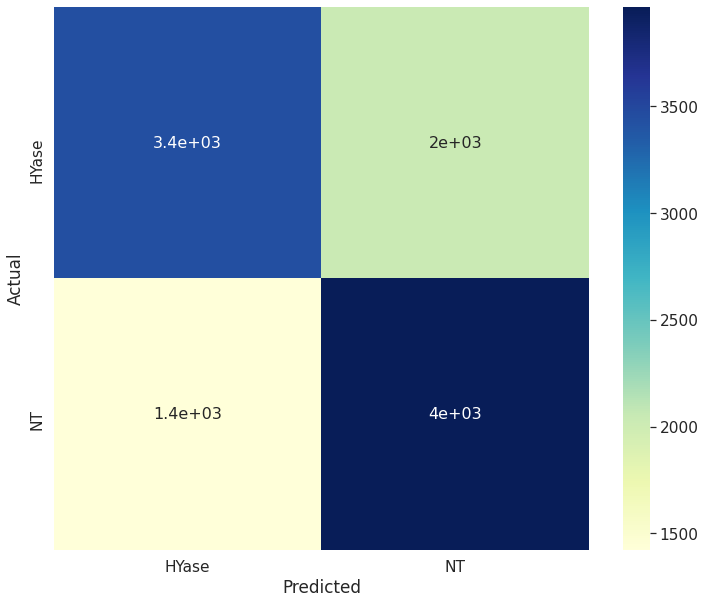

In [32]:
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

In [1]:
explainer = shap.TreeExplainer(booster) #using booster instead of bst
shap_values = explainer.shap_values(X_test[features])

NameError: name 'shap' is not defined

In [78]:
shap_values

[array([[ 8.3375513e-04,  8.6603605e-04,  2.2846546e-03, ...,
         -2.2749766e-03, -9.0404255e-03, -2.5162464e-01],
        [-3.8469546e-03, -2.5222567e-03,  5.9714946e-03, ...,
         -3.8494520e-02, -7.1586952e-02, -2.9800838e-01],
        [-8.3276664e-04,  3.1203730e-05,  3.5601060e-03, ...,
          4.8260015e-02,  2.2097914e-02,  6.2402483e-02],
        ...,
        [-4.6211827e-04, -5.8935047e-04, -2.8086852e-03, ...,
         -8.4610656e-04, -3.1668182e-02, -9.0932518e-02],
        [-3.5691334e-04, -3.5317551e-04,  4.0650768e-03, ...,
          2.9553207e-02, -4.1392770e-02,  4.6754244e-01],
        [-7.3787826e-04, -4.8513008e-05,  3.6776713e-03, ...,
          3.8966477e-02,  6.9689140e-02, -1.2880124e-01]], dtype=float32),
 array([[ 3.7183461e-04,  7.8958197e-05, -1.6621919e-03, ...,
          1.8647588e-03,  8.6251087e-03,  2.5332338e-01],
        [ 3.1760096e-04,  1.4084945e-03, -4.3478557e-03, ...,
          4.0774684e-02,  7.1911901e-02,  3.1330666e-01],
        [-3.2227405e-03,  3.4861092e-04, -1.6655672e-03, ...,
         -4.7151856e-02, -2.1356964e-02, -5.9987433e-02],
        ...,
        [ 2.0234624e-04, -4.7386164e-04,  4.1932957e-03, ...,
         -1.8304632e-03,  2.9896695e-02,  1.1271526e-01],
        [ 5.7086069e-04,  1.3681068e-04, -1.4867990e-03, ...,
         -3.4490068e-02,  4.4812508e-02, -4.8292470e-01],
        [ 3.7638919e-04,  3.2663037e-04, -1.5540317e-03, ...,
         -4.0062226e-02, -7.5616650e-02,  1.4551419e-01]], dtype=float32)]

In [68]:
c_NT = '#E69F00'
c_HYase = '#56B4E9'
#c_ChABC = '#009E73'

colors = [c_HYase, c_NT, c_ChABC]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])

In [69]:
class_inds

array([1, 0])

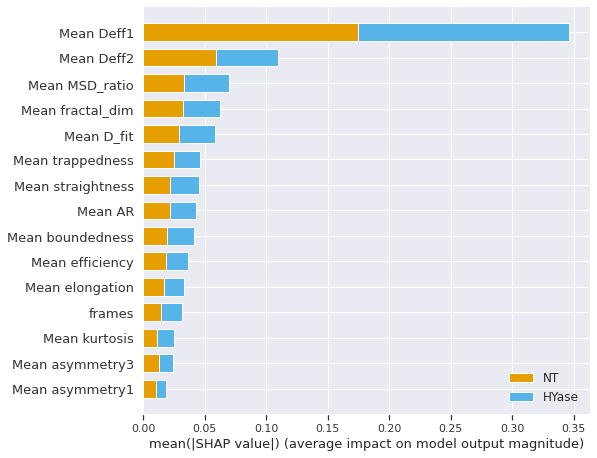

In [70]:
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)

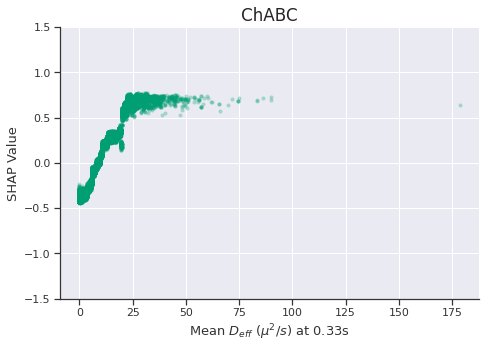

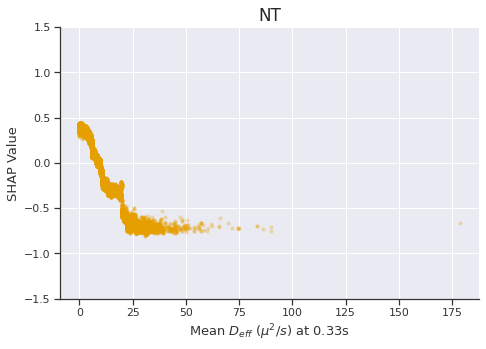

In [160]:
plt.ioff()
%matplotlib inline

figsize = (7.5, 5)
bottom = -1.5
top = 1.5
for i in range(len(shap_values)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean Deff1", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.3, ax=ax, show=False)
    ax.set_xlabel(r'Mean $D_{eff}$ ($\mu^2/s$) at 0.33s')
    ax.set_ylabel('SHAP Value')
    ax.set_title(class_names[i])

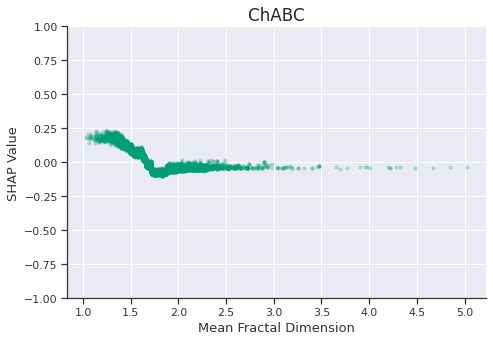

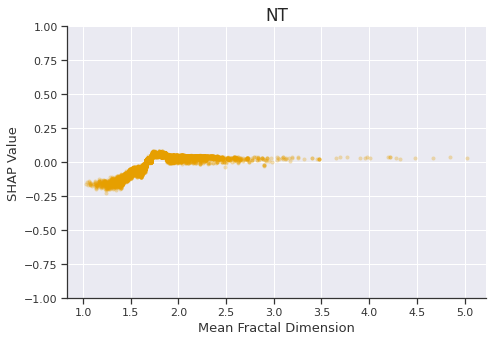

In [161]:
figsize = (7.5, 5)
bottom = -1
top = 1
for i in range(len(shap_values)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean fractal_dim", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.3, ax=ax, show=False)
    ax.set_xlabel('Mean Fractal Dimension')
    ax.set_ylabel('SHAP Value')
    ax.set_title(class_names[i])

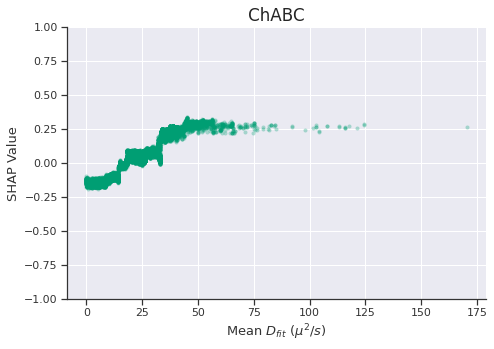

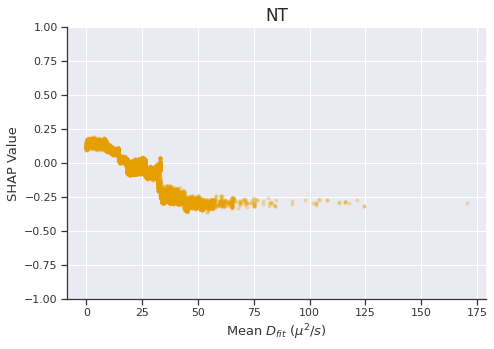

In [162]:
figsize = (7.5, 5)
bottom = -1
top = 1
for i in range(len(shap_values)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean D_fit", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.3, ax=ax, show=False)
    ax.set_xlabel(r'Mean $D_{fit}$ ($\mu^2/s$)')
    ax.set_ylabel('SHAP Value')
    ax.set_title(class_names[i])

Text(0.5, 1.0, 'Top 5 Features for NT')

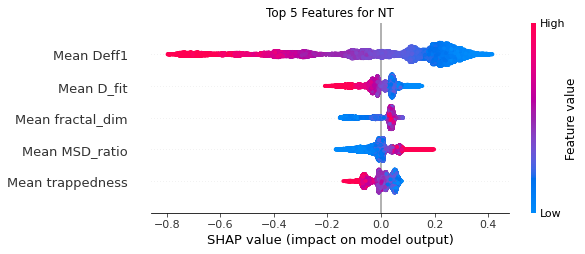

In [22]:
figsize = (7.5, 5)
fig = plt.figure(figsize=figsize)
ax = fig.gca()
shap.summary_plot(shap_values[1], X_test[features], max_display=5, class_names = class_names, title = 'SHAP Value for P14', show=False)
ax.set_title('Top 5 Features for NT')